# Sentiment Analysis with pytorch implementation of BERT

> TL;DR In this tutorial, you'll learn how to fine-tune BERT for sentiment analysis. You'll do the required text preprocessing (special tokens, padding, and attention masks) and build a Sentiment Classifier using the amazing Transformers library by Hugging Face!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You'll learn how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Let's get started!

In [1]:
#@title Watch the video tutorial

# from IPython.display import YouTubeVideo
# YouTubeVideo('8N-nM3QW7O0', width=720, height=420)

In [2]:
!nvidia-smi

Mon Jun 14 05:31:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    88W / 149W |      0MiB / 11441MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [3]:
!pip install -q -U watermark

In [4]:
# !pip install -qq transformers
!pip install -q transformers==2.8 

In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.3
IPython version      : 7.4.0

numpy       : 1.19.5
pandas      : 0.25.0
torch       : 1.0.1.post2
transformers: 2.8.0



In [6]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [7]:
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)

# df = df[:1000]
df.head()

is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...

In [8]:
df.shape

(28619, 3)

We have about 16k examples. Let's check for missing values:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
is_sarcastic    28619 non-null int64
headline        28619 non-null object
article_link    28619 non-null object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


Great, no missing values in the score and review texts! Do we have class imbalance?

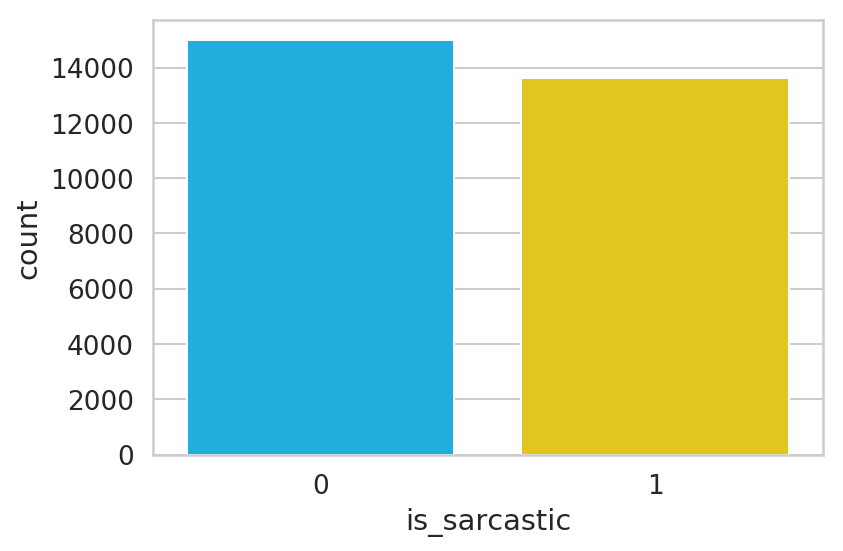

In [10]:
sns.countplot(df.is_sarcastic)
plt.xlabel('is_sarcastic');

That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment:

In [11]:
class_names = ['yes', 'no']

The balance was (mostly) restored.

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [13]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [14]:
df.headline[0]

'thirtysomething scientists unveil doomsday clock of hair loss'

In [15]:
# sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
sample_txt = df.headline[0]

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [16]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: thirtysomething scientists unveil doomsday clock of hair loss
   Tokens: ['thirty', '##some', '##thing', 'scientists', 'un', '##ve', '##il', 'doom', '##sd', '##ay', 'clock', 'of', 'hair', 'loss']
Token IDs: [4228, 14045, 20744, 6529, 4895, 3726, 4014, 12677, 16150, 4710, 5119, 1997, 2606, 3279]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [17]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [18]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [19]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [20]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [21]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [22]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  4228, 14045, 20744,  6529,  4895,  3726,  4014, 12677, 16150,
         4710,  5119,  1997,  2606,  3279,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

The attention mask has the same length:

In [23]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [24]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'thirty',
 '##some',
 '##thing',
 'scientists',
 'un',
 '##ve',
 '##il',
 'doom',
 '##sd',
 '##ay',
 'clock',
 'of',
 'hair',
 'loss',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [25]:
token_lens = []

for txt in df.headline:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

and plot the distribution:

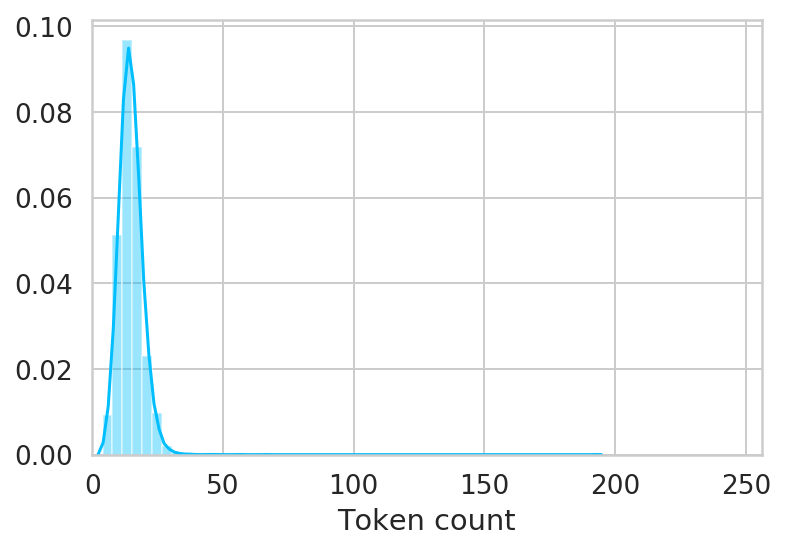

In [26]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [27]:
# MAX_LEN = 160
MAX_LEN = 50

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [28]:
class HeadlineDataset(Dataset):

  def __init__(self, headlines, targets, tokenizer, max_len):
    self.headlines = headlines
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.headlines)
  
  def __getitem__(self, item):
    headline = str(self.headlines[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      headline,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'headline_text': headline,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [29]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [30]:
df_train.shape, df_val.shape, df_test.shape

((20033, 3), (4293, 3), (4293, 3))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [31]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = HeadlineDataset(
    headlines=df.headline.to_numpy(),
    targets=df.is_sarcastic.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [32]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [33]:
data = next(iter(train_data_loader))
# data.keys()
# data

In [34]:
# data = iter(train_data_loader)
# next(data)


In [35]:
print(data['headline_text'])
print(len(data['headline_text']))
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

['american express to offer 5 months of paternity and maternity leave', 'watch: dolphin knocks stand-up paddleboarder off his board', 'man who enjoys thing informed he is wrong', "jonathan lipnicki to star as young 'dark helmet' in spaceballs prequel", "publicist worried kanye west's support of trump will damage his carefully crafted public image as a manic self-absorbed lunatic", "this congressman's story perfectly illustrates gop obstructionism toward obama", 'vilsack reprimanded for spending work hours writing corn blog', 'senate bill to end u.s. role in yemen war rejected by house raytheon executives', 'pepperidge factory farm under fire for inhumane treatment of milanos', "hillary clinton celebrates confederate flag's removal at mlk day ceremony", 'report: gop candidate against gay marriage was once a gay female impersonator', "an apology expert analyzes the explanation for melania trump's plagiarism", "a bunch of stars just wrapped ava duvernay's 'a wrinkle in time'", "donald tru



```
# This is formatted as code
```

## Sarcasm Detection with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [36]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, output_attentions=True)

And try to use it on the encoding of our sample text:

In [37]:
last_hidden_state, pooled_output, attension_outputs = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)


In [38]:
print(last_hidden_state.shape)
print(pooled_output.shape)
print(len(attension_outputs))

torch.Size([1, 32, 768])
torch.Size([1, 768])
12


In [39]:
last_hidden_state, pooled_output, attension_outputs = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [40]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [41]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [42]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [43]:
# model_config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True)
# bert_pre = BertModel.from_pretrained('bert-base-uncased', config=model_config)

In [44]:
class SarcasmDetector(nn.Module):

    def __init__(self, n_classes):
        super(SarcasmDetector, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, output_hidden_states=True, output_attentions=True)
#         self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, output_attentions=True)
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
#         print(self.bert.config)
        _, pooled_output, hidden_states, weighted_output = self.bert(
#         _, pooled_output, weighted_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.dropout(pooled_output)
        return self.out(output), hidden_states

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [45]:
model = SarcasmDetector(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [46]:
data.keys()

dict_keys(['headline_text', 'input_ids', 'attention_mask', 'targets'])

In [47]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 50])
torch.Size([16, 50])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [48]:
len(model(input_ids, attention_mask))

2

In [49]:
F.softmax(model(input_ids, attention_mask)[0], dim=1)

tensor([[0.4585, 0.5415],
        [0.6173, 0.3827],
        [0.5153, 0.4847],
        [0.5496, 0.4504],
        [0.5491, 0.4509],
        [0.5857, 0.4143],
        [0.5053, 0.4947],
        [0.7012, 0.2988],
        [0.5585, 0.4415],
        [0.6048, 0.3952],
        [0.5249, 0.4751],
        [0.4235, 0.5765],
        [0.4521, 0.5479],
        [0.6292, 0.3708],
        [0.5647, 0.4353],
        [0.7335, 0.2665]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [50]:
EPOCHS = 1

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [51]:
total_steps

1253

In [52]:

from datetime import datetime
date_time = datetime.now().strftime("%B%d%Y_%H_%M_%S")
print("date and time:",date_time)

RUN=date_time
print(RUN)

date and time: June142021_05_33_21
June142021_05_33_21


In [53]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


dim_reducer = TSNE(n_components=2)
#dim_reducer = PCA(n_components=2)

def visualize_layerwise_embeddings(hidden_states,masks,ys,epoch,title,RUN,layers_to_visualize=[0,1,2,3,8,9,10,11]):
    print('visualize_layerwise_embeddings for',title,'epoch',epoch)
    global dim_reducer
    imgName = datetime.now().strftime("%B%d%Y_%H_%M_%S")
    !mkdir -p ./tmp/plots/{RUN}/{title}/
    num_layers = len(layers_to_visualize)
    fig = plt.figure(figsize=(24,(num_layers/4)*6)) #each subplot of size 6x6
    ax = [fig.add_subplot(num_layers/4,4,i+1) for i in range(num_layers)]
    ys = ys.numpy().reshape(-1)
    # print(ys)
    for i,layer_i in enumerate(layers_to_visualize):#range(hidden_states):
        layer_hidden_states = hidden_states[layer_i]
        # print(layer_hidden_states.shape)
        averaged_layer_hidden_states = torch.div(layer_hidden_states.type(torch.FloatTensor).sum(dim=1),masks.type(torch.FloatTensor).sum(dim=1,keepdim=True))
        # print(averaged_layer_hidden_states.shape)
        layer_dim_reduced_vectors = dim_reducer.fit_transform(averaged_layer_hidden_states.numpy())
        # print(layer_dim_reduced_vectors.shape)
        df = pd.DataFrame.from_dict({'x':layer_dim_reduced_vectors[:,0],'y':layer_dim_reduced_vectors[:,1],'label':ys})
        # print(df.head())
        df.label = df.label.astype(int)
        sns.scatterplot(data=df,x='x',y='y',hue='label',ax=ax[i])
        fig.suptitle(f"{title}: epoch {epoch}")
        ax[i].set_title(f"layer {layer_i+1}")
    
    fig.savefig(f"./tmp/plots/{RUN}/{title}/{epoch}_{imgName}.png")
    print()

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

----------
outputs.shape 16
ad tensor([ 0.0266,  0.2582,  0.1126,  0.0303, -0.0711,  0.2999,  0.0685,  0.1699,
         0.0252,  0.3505, -0.1131, -0.1322, -0.0592,  0.5359,  0.0213,  0.4250],
       device='cuda:0', grad_fn=<MaxBackward0>)
preds tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
loss.shape torch.Size([])
targets.shape tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')

In [54]:
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples,
    epoch,
    RUN
    ):
    model = model.train()

    losses = []
    correct_predictions = 0
    
    train_hidden_states = None
    
    train_masks,train_ys = torch.zeros(0,MAX_LEN),torch.zeros(0,1)

    count =0
    for d in data_loader:
        count+=1
#         print(count,'-', end ="")
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs, hidden_states = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _,preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        with torch.no_grad():
 
            if count%10 == 0:
                print(count, end ="-")
                if type(train_hidden_states) == type(None):
                    train_hidden_states = tuple(layer_hidden_states.cpu() for layer_hidden_states in hidden_states)
                else:
                    train_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.cpu()])for layer_hidden_state_all,layer_hidden_state_batch in zip(train_hidden_states,hidden_states))

                train_masks = torch.cat([train_masks,attention_mask.cpu().type(torch.FloatTensor)])
                train_ys = torch.cat([train_ys,targets.cpu().type(torch.FloatTensor).view(-1,1)])
                
    
    print('visualising train data')
    visualize_layerwise_embeddings(train_hidden_states,train_masks,train_ys,epoch,'train_data', RUN)    
    return correct_predictions.double() / n_examples, np.mean(losses), train_hidden_states

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [55]:
def eval_model(model, data_loader, loss_fn, device, n_examples, epoch, RUN):
    model = model.eval()

    losses = []
    correct_predictions = 0

    train_hidden_states = None
    
    train_masks,train_ys = torch.zeros(0,MAX_LEN),torch.zeros(0,1)
    
    count=0
    with torch.no_grad():
        for d in data_loader:
            count+=1

#             print('-', end ="")
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)


            outputs, hidden_states = model(
                input_ids=input_ids, 
                attention_mask=attention_mask
            )
            _,preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            with torch.no_grad():
             if count%10 == 0:
                print(count, end ="-")
                
                if type(train_hidden_states) == type(None):
                    train_hidden_states = tuple(layer_hidden_states.cpu() for layer_hidden_states in hidden_states)
                else:
                    train_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.cpu()])for layer_hidden_state_all,layer_hidden_state_batch in zip(train_hidden_states,hidden_states))
                
                train_masks = torch.cat([train_masks,attention_mask.cpu().type(torch.FloatTensor)])
                train_ys = torch.cat([train_ys,targets.cpu().type(torch.FloatTensor).view(-1,1)])
                
    print('visualising val data')
    visualize_layerwise_embeddings(train_hidden_states,train_masks,train_ys,epoch,'val_data', RUN)    
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [56]:
history = defaultdict(list)

Epoch 1/1
----------
10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-520-530-540-550-560-570-580-590-600-610-620-630-640-650-660-670-680-690-700-710-720-730-740-750-760-770-780-790-800-810-820-830-840-850-860-870-880-890-900-910-920-930-940-950-960-970-980-990-1000-1010-1020-1030-1040-1050-1060-1070-1080-1090-1100-1110-1120-1130-1140-1150-1160-1170-1180-1190-1200-1210-1220-1230-1240-1250-visualising train data
visualize_layerwise_embeddings for train_data epoch 0


Train loss 0.2650442185030517 accuracy 0.8925273299056556
running val data
10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-visualising val data
visualize_layerwise_embeddings for val_data epoch 0


Val   loss 0.19654708789128353 accuracy 0.9212671791288144

[tensor(0.8925, device='cuda:0', dtype=torch.float64)]
CPU times: user 13min 3

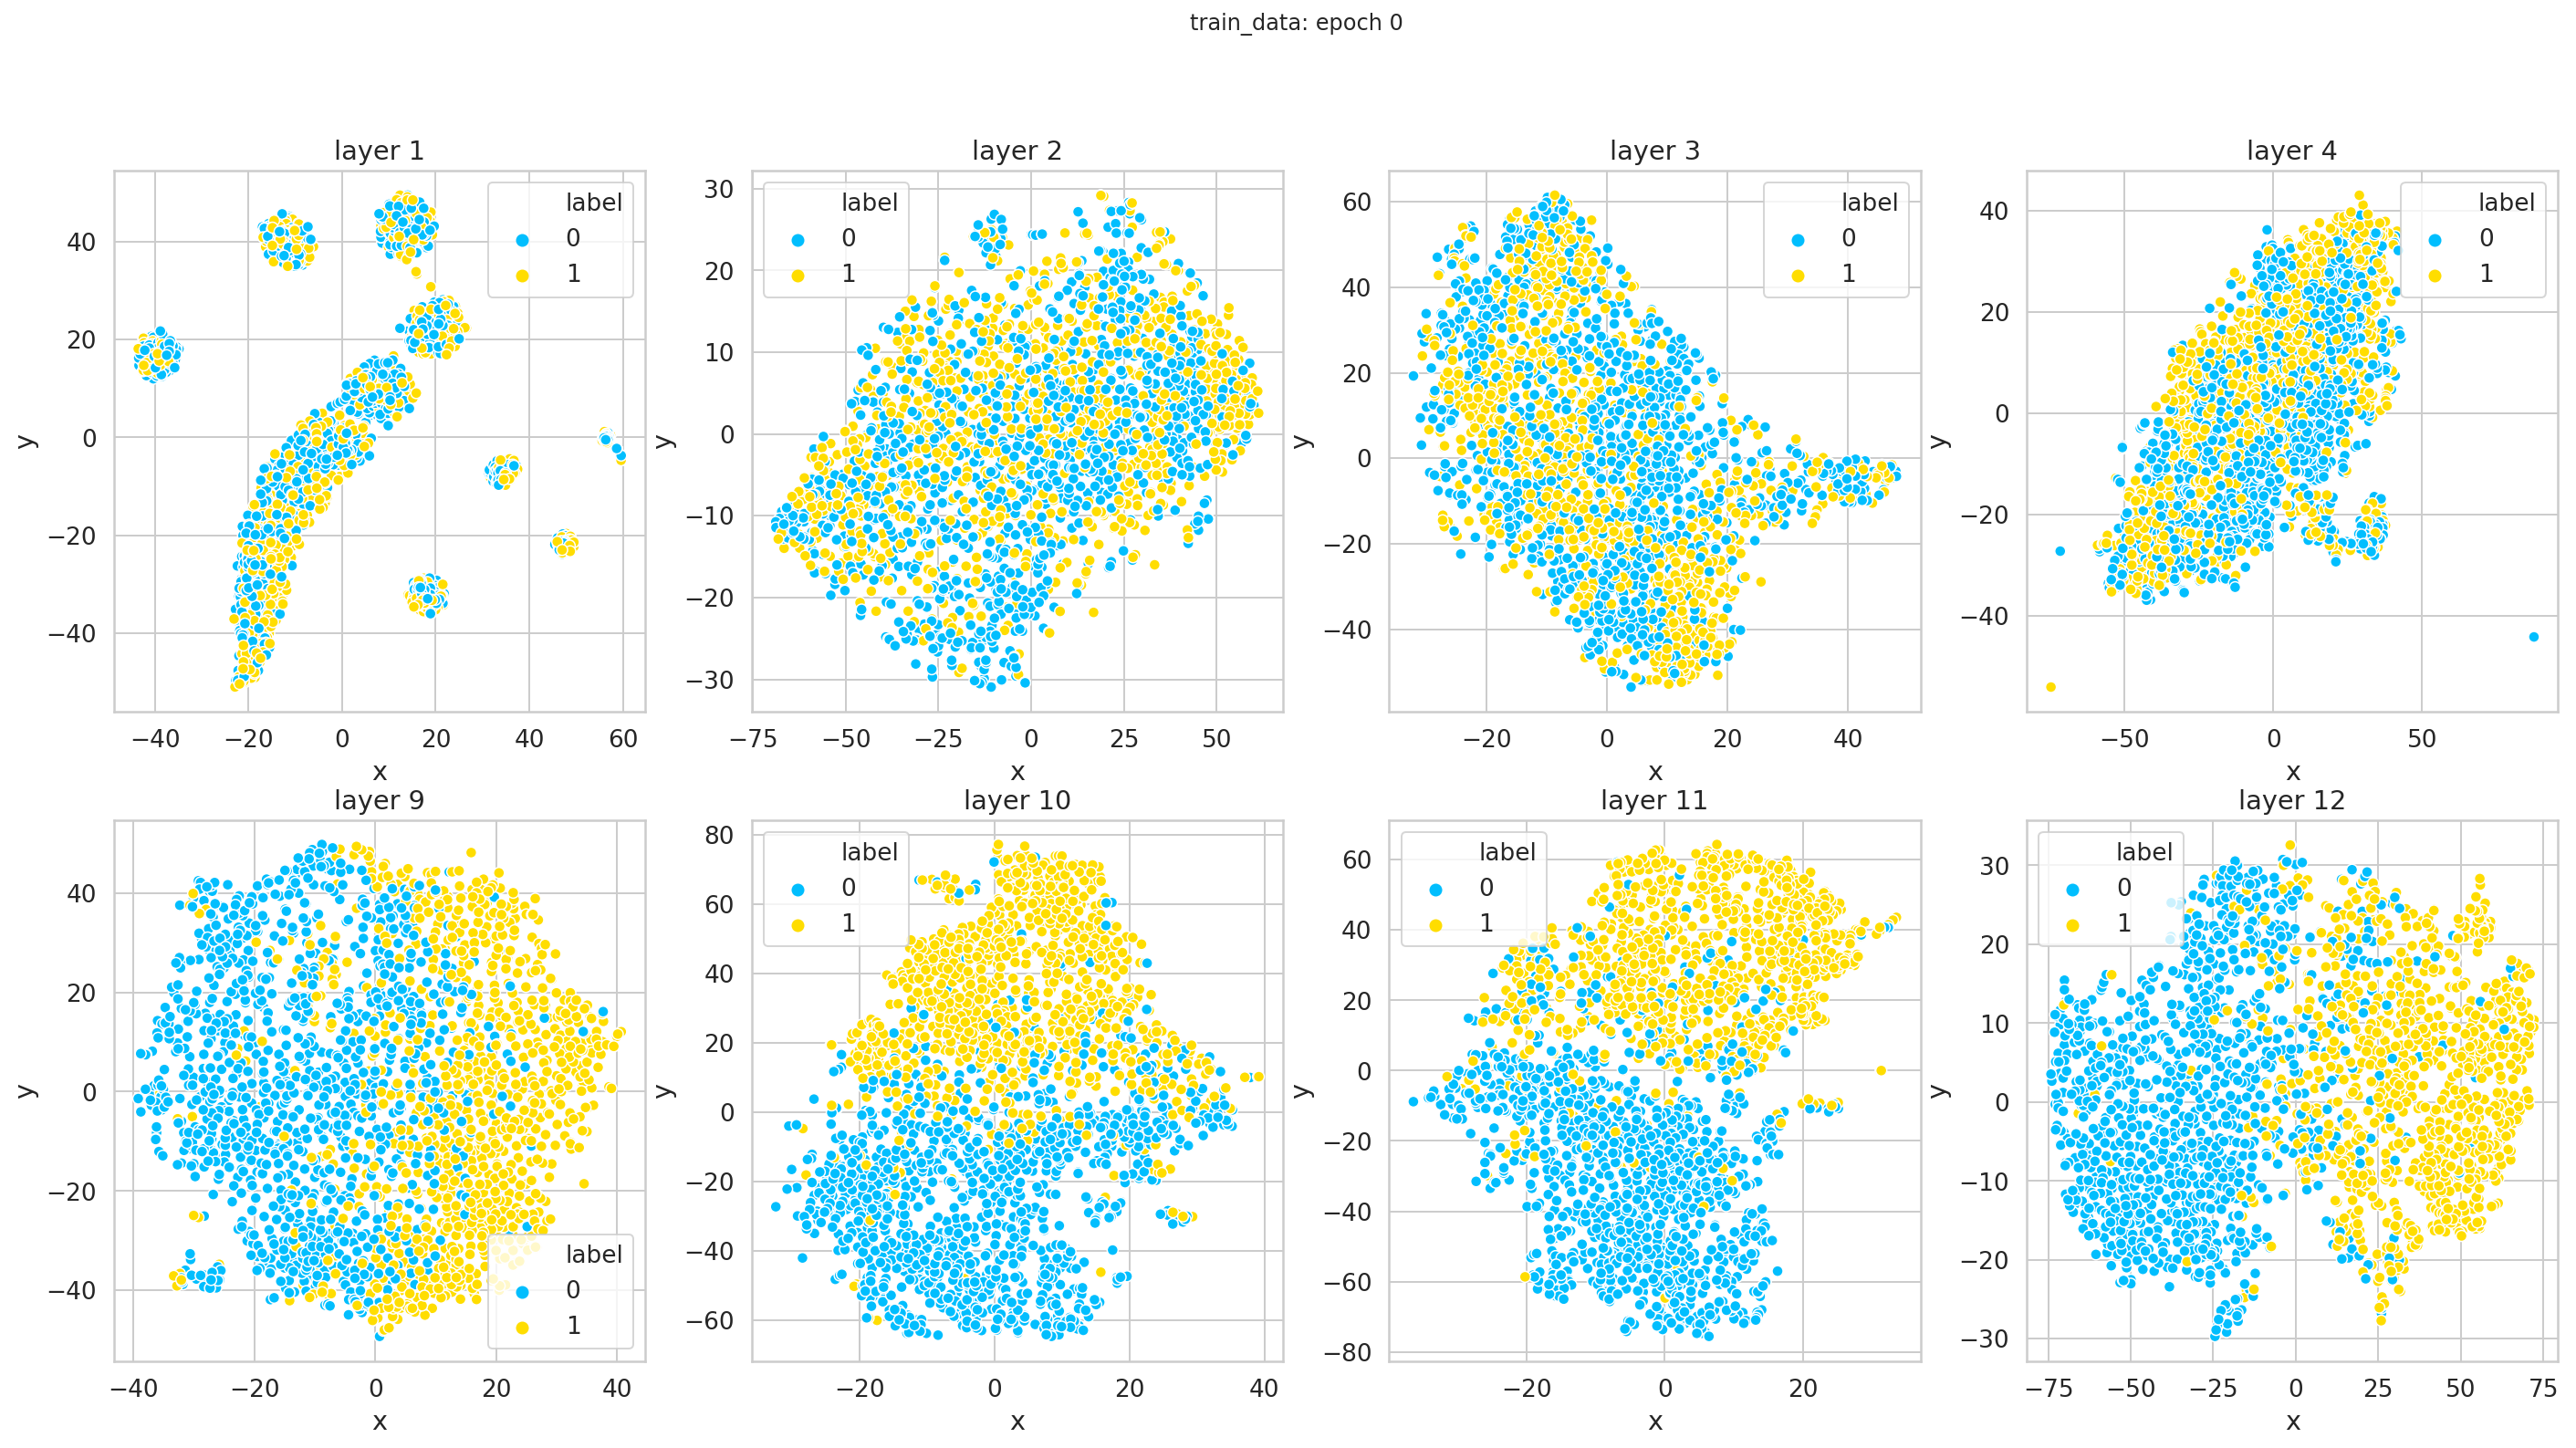

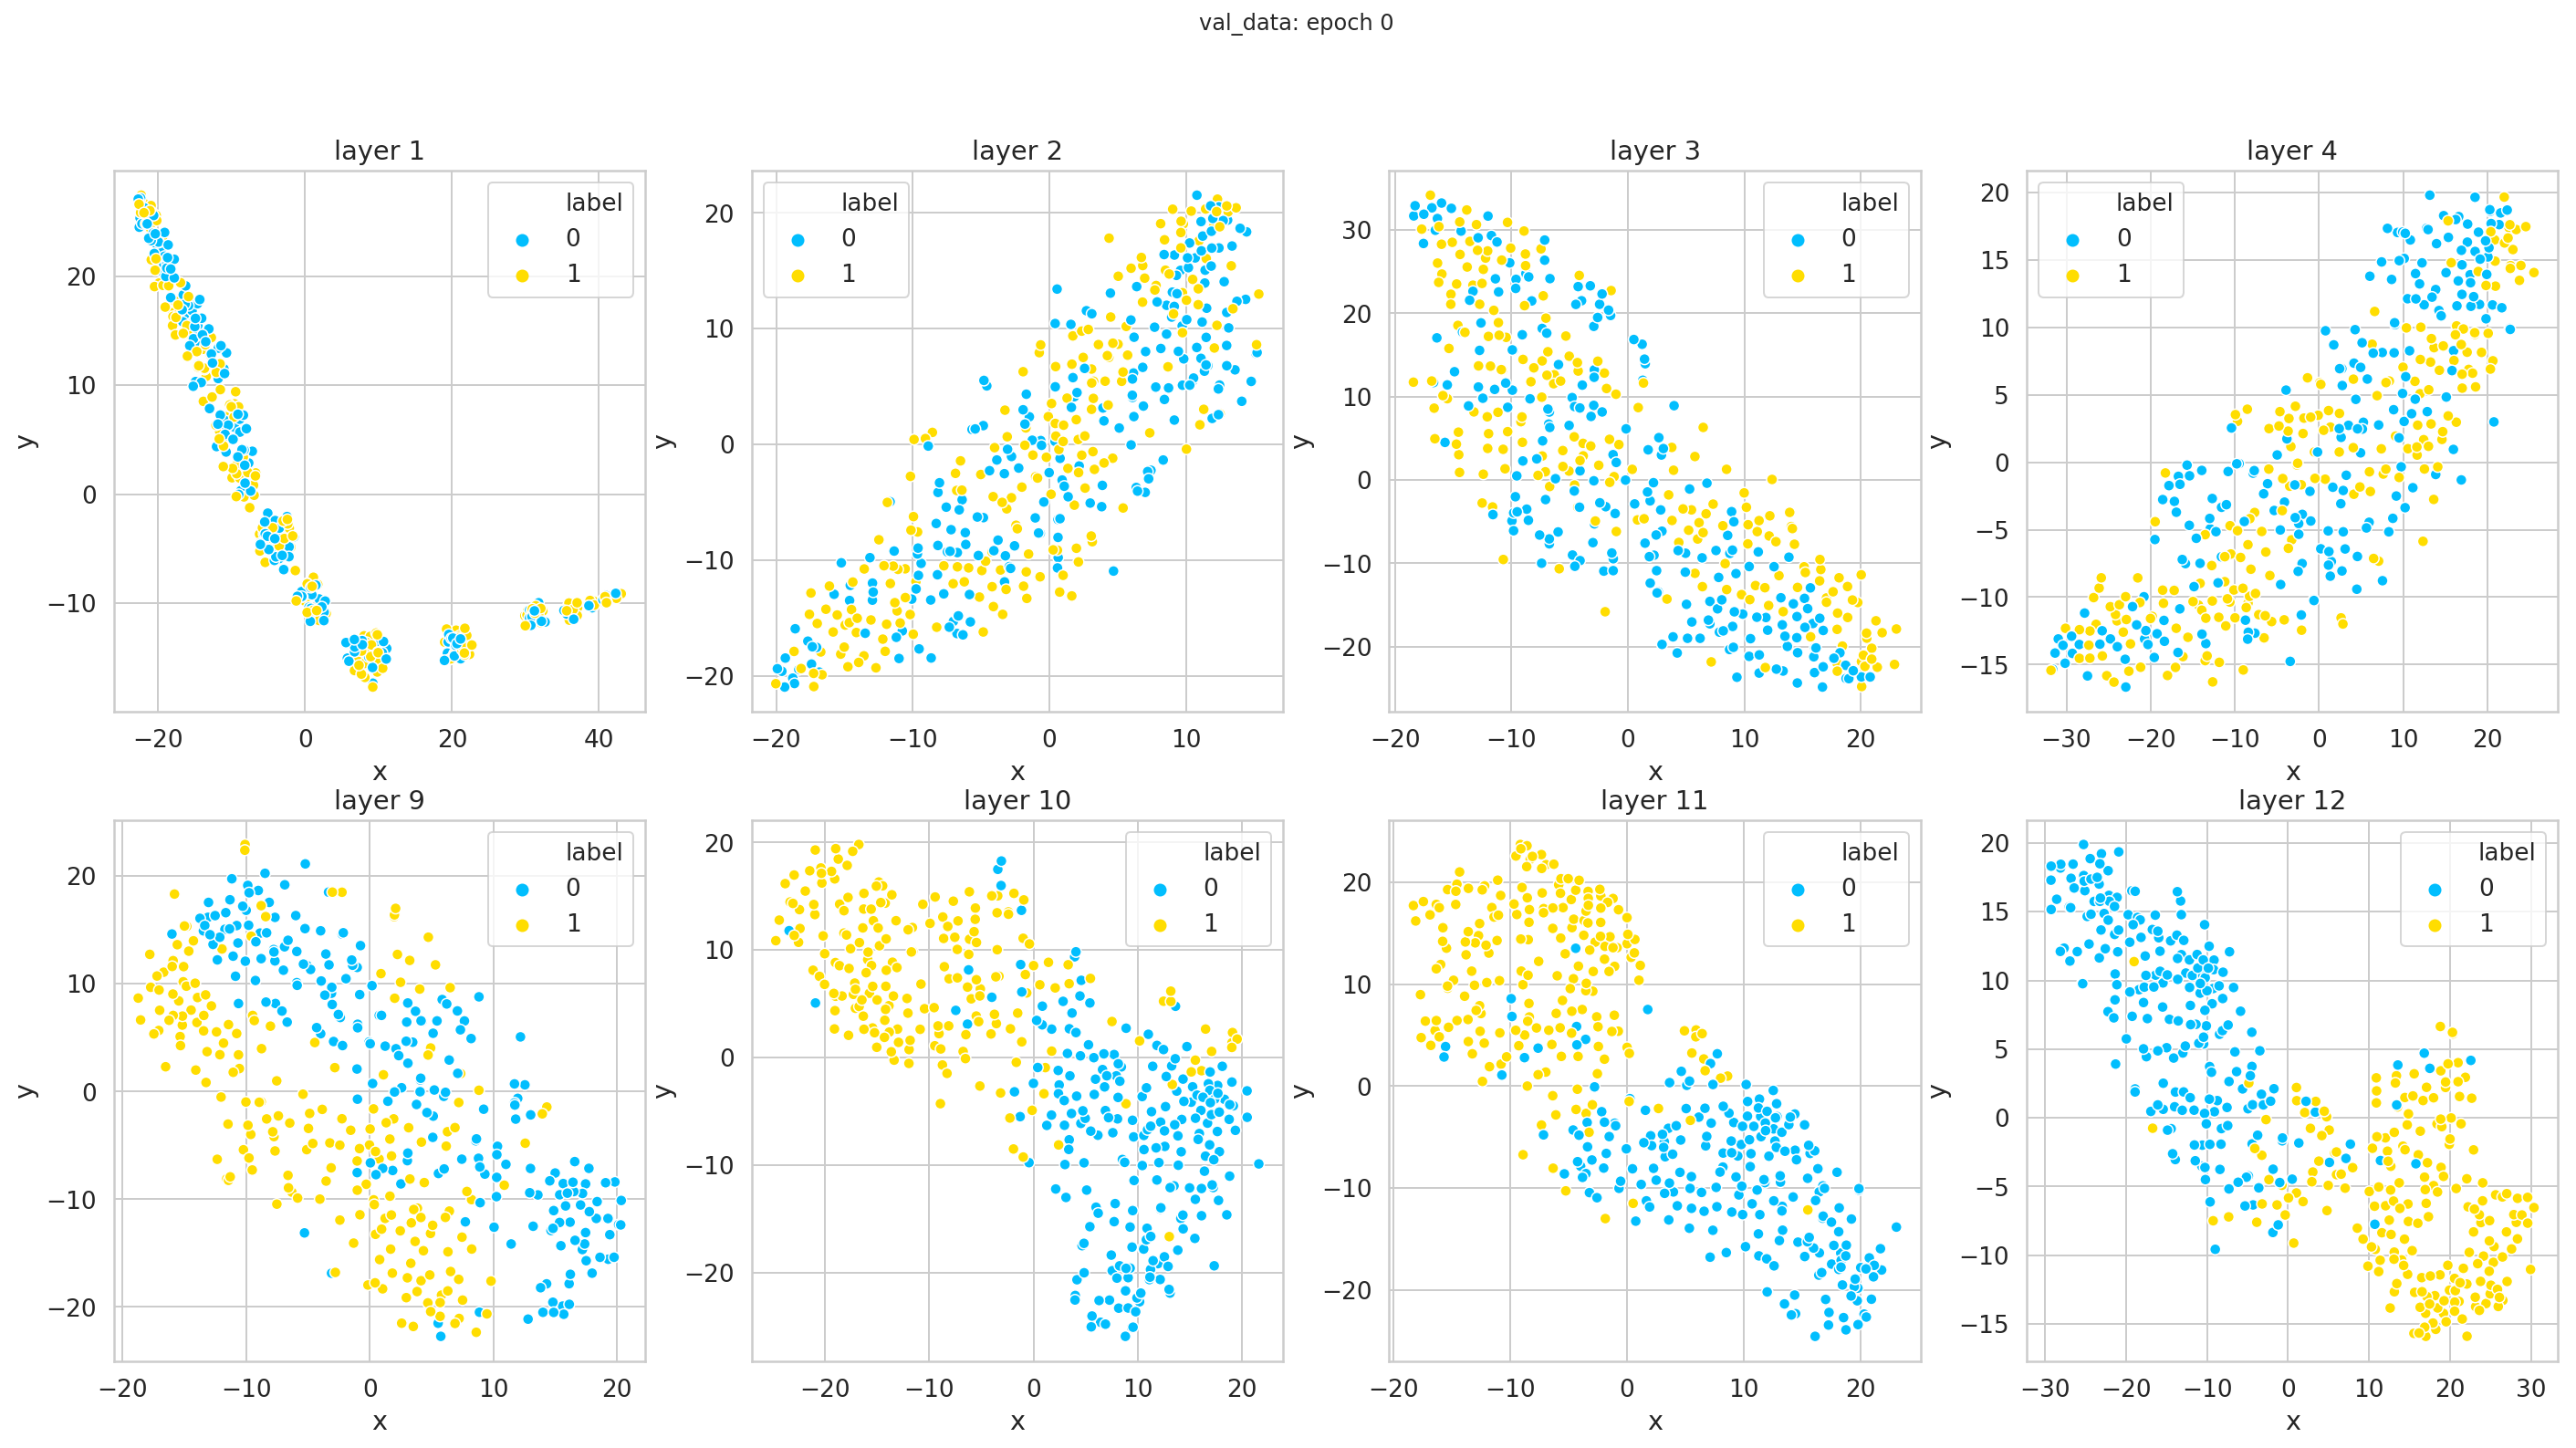

In [57]:
%%time

    
best_accuracy = 0
for epoch in range(EPOCHS):

    train_hidden_states = None
    val_hidden_states = None
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss, train_hidden_states = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train),
        epoch,
        RUN
    )
    print()
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
#     print('visualising train data')

    print('running val data')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val),
        epoch,
        RUN
    )
#     print('visualising val data')

    print()
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    print(history['train_acc'])
    if val_acc > best_accuracy:
        
        !mkdir -p ./models/{val_acc}/{RUN}

        torch.save(model.state_dict(), f'./models/{val_acc}/{RUN}/best_model_state_{val_acc}.bin')
        best_accuracy = val_acc
        
        


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

In [58]:
import imageio,glob

In [59]:
val_images = []
for filename in sorted(glob.glob(f'./tmp/plots/{RUN}/val_data/*')):
    print('appending for',filename)
    val_images.append(imageio.imread(filename))
imageio.mimsave(f'./tmp/plots/{RUN}/val.gif', val_images,duration=len(val_images))

train_images = []
for filename in sorted(glob.glob(f'./tmp/plots/{RUN}/train_data/*')):
    print('appending for',filename)
    train_images.append(imageio.imread(filename))
imageio.mimsave(f'./tmp/plots/{RUN}/train.gif', train_images,duration=len(train_images)/2)

appending for ./tmp/plots/June142021_05_33_21/val_data/0_June142021_05_48_35.png
appending for ./tmp/plots/June142021_05_33_21/train_data/0_June142021_05_44_53.png


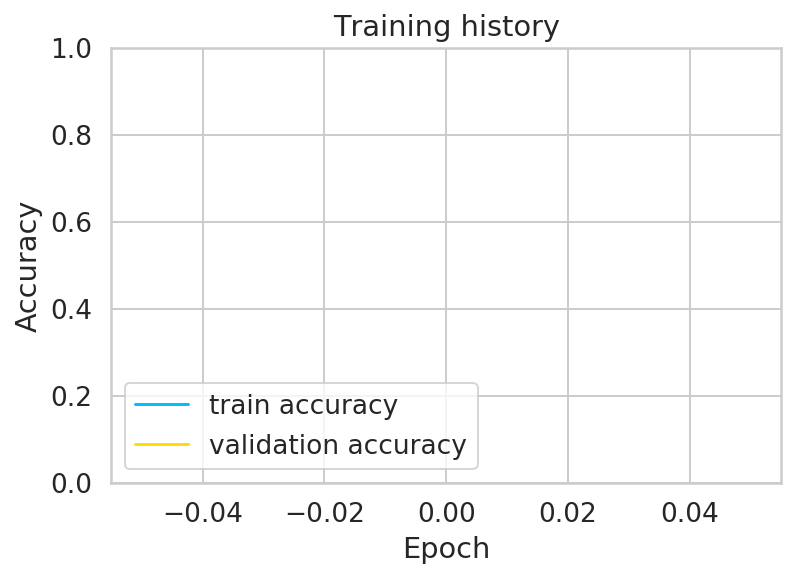

In [60]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-visualising val data
visualize_layerwise_embeddings for val_data epoch 100



0.9210342417889588

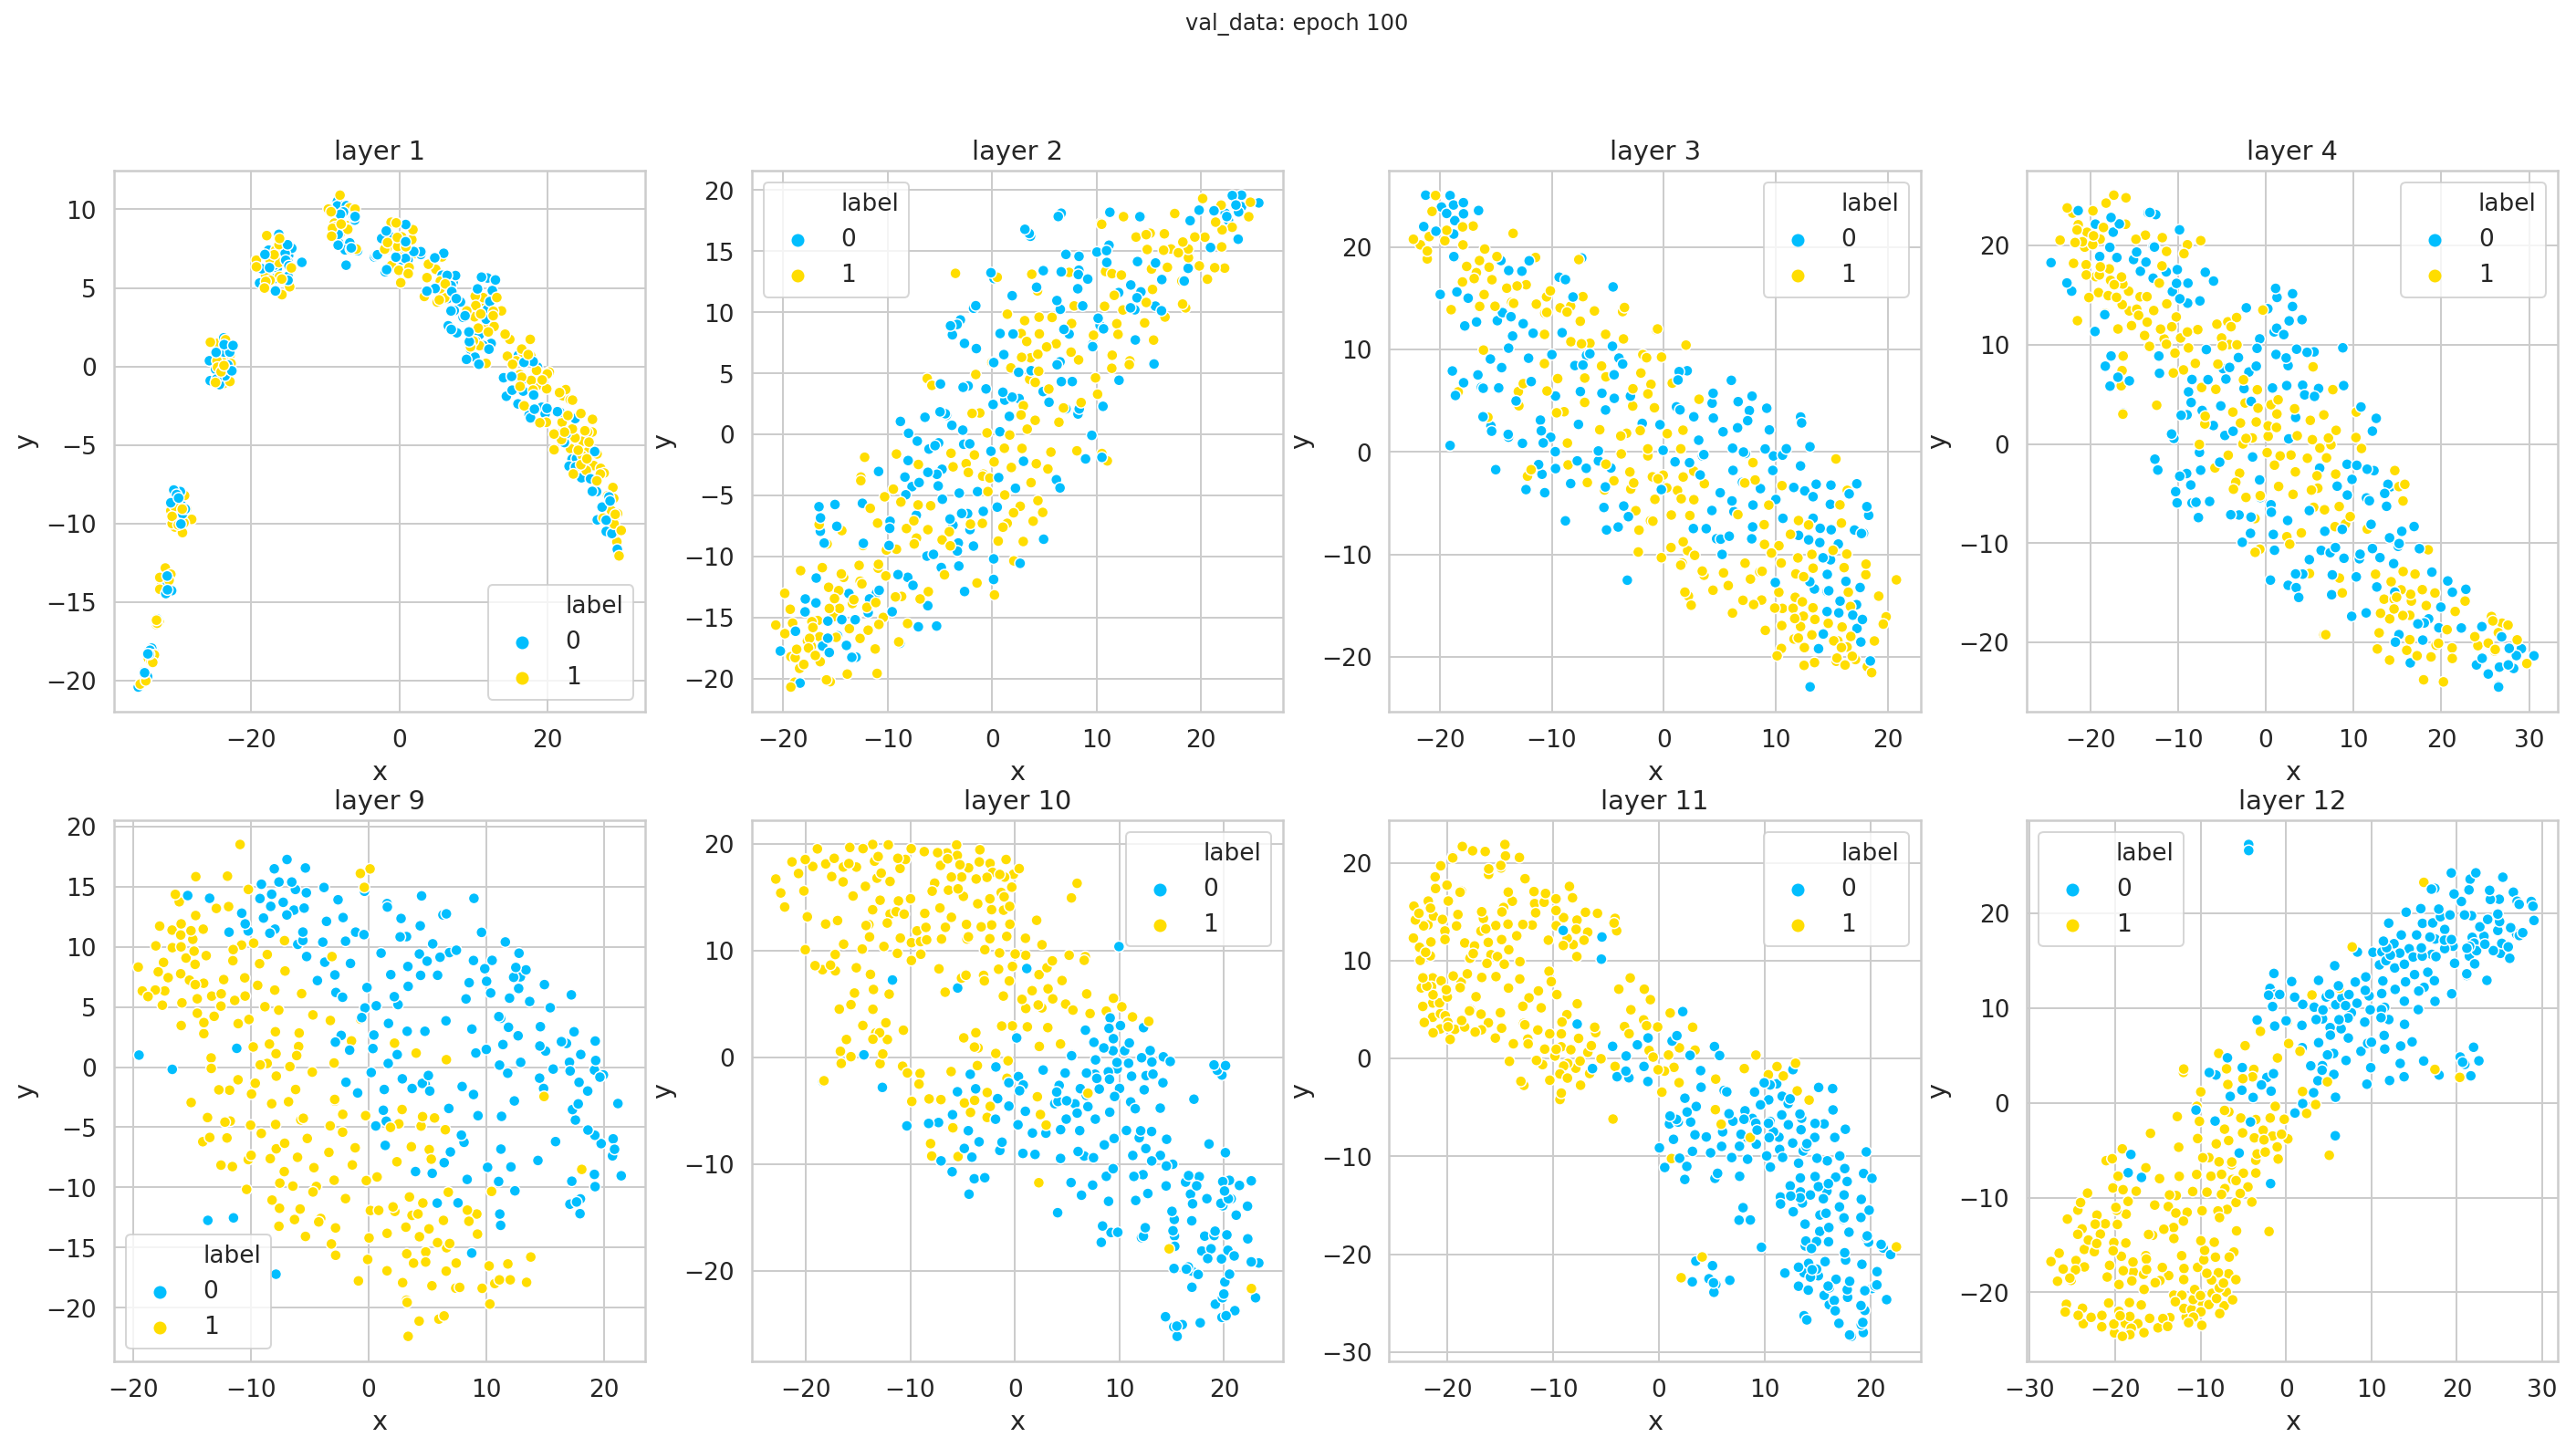

In [61]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test),
    100,
    RUN
)

test_acc.item()

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [62]:
def get_predictions(model, data_loader):
    model = model.eval()

    headline_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["headline_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs, hidden_states = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            headline_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return headline_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [63]:
y_headline_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

Let's have a look at the classification report

In [64]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         yes       0.92      0.93      0.92      2237
          no       0.92      0.91      0.92      2056

   micro avg       0.92      0.92      0.92      4293
   macro avg       0.92      0.92      0.92      4293
weighted avg       0.92      0.92      0.92      4293



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

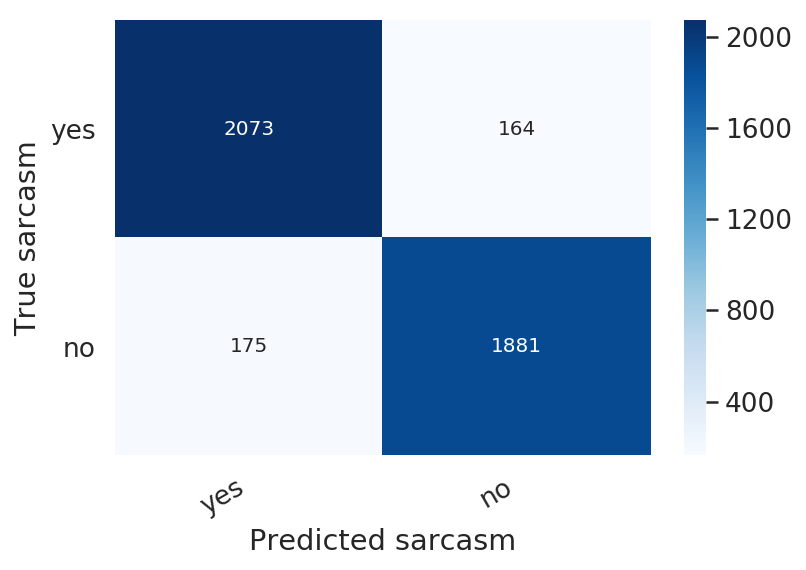

In [65]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sarcasm')
    plt.xlabel('Predicted sarcasm');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [66]:
idx = 2

headline_text_ = y_headline_texts[idx]
true_sarcasm_ = y_test[idx]
pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
})

In [67]:
print("\n".join(wrap(headline_text_)))
print()
print(f'True sarcasm: {class_names[true_sarcasm_]}')

kenya claims to have killed over 100 militants in somalian raid

True sarcasm: yes


Now we can look at the confidence of each sentiment of our model:

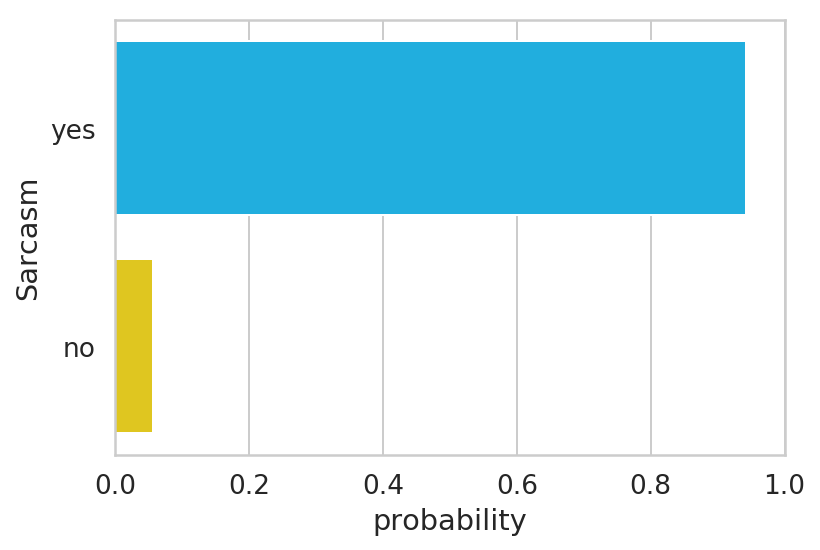

In [68]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Sarcasm')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [69]:
headline_text_raw = "PM Modi calls up Bengal governor on violence, Didi smells ‘President's rule’"

We have to use the tokenizer to encode the text:

In [70]:
encoded_review = tokenizer.encode_plus(
    headline_text_raw,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

Let's get the predictions from our model:

In [71]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output, hidden_states = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Headline sarcasm text: {headline_text_raw}')
print(f'Sarcasm  : {class_names[prediction]}')

Headline sarcasm text: PM Modi calls up Bengal governor on violence, Didi smells ‘President's rule’
Sarcasm  : yes


## Summary

Nice job! You learned how to use BERT for sentiment analysis. You built a custom classifier using the Hugging Face library and trained it on our app reviews dataset!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Next, we'll learn how to deploy our trained model behind a REST API and build a simple web app to access it.

## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)

In [72]:
model

SarcasmDetector(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
    

In [73]:
!pip install -q bertviz

In [74]:

encoding_visualizer = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
)

last_hidden_state, pooled_output, attention_weights = bert_model(
    input_ids=encoding_visualizer['input_ids'], 
    attention_mask=encoding_visualizer['attention_mask']
)





sample_txt_tokens = tokenizer.convert_ids_to_tokens(encoding_visualizer['input_ids'][0])

print(sample_txt, "\n")
print(encoding_visualizer['input_ids'], "\n")
print(encoding_visualizer['attention_mask'], "\n")
print(last_hidden_state.shape, "\n")
print(pooled_output.shape, "\n")
print(len(attention_weights), "\n")
print(sample_txt_tokens, "\n")


thirtysomething scientists unveil doomsday clock of hair loss 

tensor([[  101,  4228, 14045, 20744,  6529,  4895,  3726,  4014, 12677, 16150,
          4710,  5119,  1997,  2606,  3279,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]) 

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]) 

torch.Size([1, 32, 768]) 

torch.Size([1, 768]) 

12 

['[CLS]', 'thirty', '##some', '##thing', 'scientists', 'un', '##ve', '##il', 'doom', '##sd', '##ay', 'clock', 'of', 'hair', 'loss', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'] 



Commeted below as heavy images, and Gif increased the size of this file itself to more than 41MB, for submission commenting them, 

In [90]:
# from bertviz import head_view
# head_view(sample_txt_attention, sample_txt_tokens)

# head_view(attention_weights, sample_txt_tokens)

In [91]:
# from bertviz import model_view
# model_view(attention_weights, sample_txt_tokens, display_mode="light")


In [92]:
# from bertviz.transformers_neuron_view import BertModel, BertTokenizer

# from bertviz.neuron_view import show
# sentence_a = "sad. asd dd dsd "
# sentence_b = "happy sd fa df"
# do_lower_case=True
# model2 = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, output_attentions=True)
# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=do_lower_case)
# model_type = 'bert'
# show(model2, model_type, tokenizer, sentence_a, sentence_a, layer=2, head=0)

In [93]:
# sentence_a

In [94]:
# sample_txt = "Oxygen supply to Delhi: HC issues show-cause to Centre on contempt"

In [95]:
# sample_txt = "thirtysomething scientists unveil doomsday clock of hair loss"

In [96]:
# show(model2, model_type, tokenizer, sample_txt, layer=2, head=0)

In [97]:

# from transformers import BertConfig, BertModel
# model_config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True)
# bert_pre = BertModel.from_pretrained('bert-base-uncased', config=model_config)

# input_ids = data['input_ids']
# attention_mask = data['attention_mask']

# print(input_ids.shape)
# print(attention_mask.shape)
# last_hidden_state, pooled_output, hidden_states, attention_weights = bert_pre(
#     input_ids=input_ids, 
#     attention_mask=attention_mask
# )

# print(last_hidden_state.shape)
# print(pooled_output.shape)
# print(len(attention_weights))
# print(len(hidden_states))


# train_hidden_states = None

# if type(train_hidden_states) == type(None):
#     train_hidden_states = tuple(layer_hidden_states.cpu() for layer_hidden_states in hidden_states)
# else:
#     train_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.cpu()])for layer_hidden_state_all,layer_hidden_state_batch in zip(train_hidden_states,hidden_states))

# epoch=1
# train_masks = attention_mask
# train_ys = data['targets']

# title = 'train_data'
# with torch.no_grad():
#     visualize_layerwise_embeddings(train_hidden_states,train_masks,train_ys,epoch,title,RUN)
